## Analyse des séries chronologiques - Partie 3 : Modèles ARMA et ARIMA

In [1]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
startDateStr = '2014/12/31'
endDateStr = '2017/12/31'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['^GSPC','DOW','AAPL','MSFT']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']
# log returns
lrets = np.log(data/data.shift(1))

Processing data for stock: ^GSPC
Processing data for stock: DOW
Processing data for stock: AAPL
Processing data for stock: MSFT
20% done...
40% done...
60% done...
80% done...


In [3]:
lrets['^GSPC'].dropna()

2014-12-31   -0.010364
2015-01-02   -0.000340
2015-01-05   -0.018447
2015-01-06   -0.008933
2015-01-07    0.011563
                ...   
2017-12-22   -0.000458
2017-12-26   -0.001059
2017-12-27    0.000791
2017-12-28    0.001832
2017-12-29   -0.005197
Name: ^GSPC, Length: 756, dtype: float64

In [4]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

#### Modèles de moyennes mobiles autorégressives - ARMA(p, q)

Le modèle ARMA est simplement la fusion entre les modèles AR(p) et MA(q) :

Les modèles AR(p) tentent de saisir (expliquer) les effets de momentum et de retour à la moyenne souvent observés sur les marchés de négociation (effets des participants au marché).
Les modèles MA(q) tentent de capturer (expliquer) les effets de choc observés dans les termes de bruit blanc. Ces effets de choc peuvent être considérés comme des événements inattendus affectant le processus d'observation, par exemple des gains surprises, une attaque terroriste, etc.
Par conséquent, un modèle ARMA tente de saisir ces deux aspects lors de la modélisation des séries chronologiques financières. Il convient de noter qu'un modèle ARMA ne prend pas en compte le regroupement de la volatilité, un phénomène empirique clé de nombreuses séries chronologiques financières dont nous parlerons plus loin.

$$x_t=\alpha_1x_{t-1}+…+\alpha_px_{t-p}+w_t+\beta_1w_{t-1}+…+\beta_qw_{t-q}$$
Où $w_t$ est un bruit blanc avec $E(w_t)=0$ et variance $\sigma^2$.

Un modèle ARMA nécessite souvent moins de paramètres qu'un modèle AR(p) ou MA(q) seul. C'est-à-dire qu'il est redondant dans ses paramètres

Simulons un processus ARMA(2, 2) avec des paramètres donnés, puis ajustons un modèle ARMA(2, 2) et voyons s'il peut estimer correctement ces paramètres. Réglons les alphas à [0,5,-0,25] et les bétas à [0,5,-0,3].

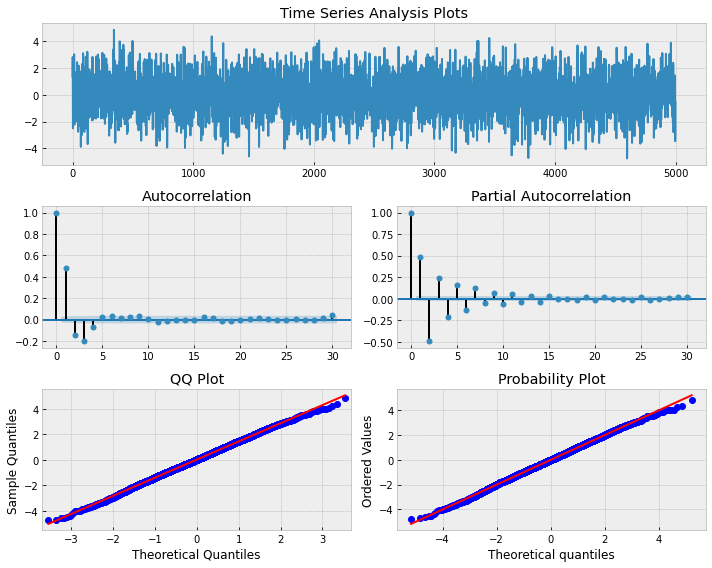

In [5]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag)

In [6]:
mdl = smt.ARMA(arma22, order=(2, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7066.336
Method:                           mle   S.D. of innovations              0.994
Date:                Tue, 29 Sep 2020   AIC                          14142.672
Time:                        21:23:30   BIC                          14175.258
Sample:                             0   HQIC                         14154.093
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.5330      0.054      9.942      0.000       0.428       0.638
ar.L2.y       -0.2462      0.015    -16.109      0.000      -0.276      -0.216
ma.L1.y        0.4519      0.055      8.284      0.0

 Pour ajuster les données à un modèle ARMA, nous utilisons le critère d'information d'Akaike (AIC) sur un sous-ensemble de valeurs pour p,q afin de trouver le modèle avec un AIC minimum, puis nous appliquons le test de Ljung-Box pour déterminer si un bon ajustement a été réalisé, pour des valeurs particulières de p,q. Si la valeur p du test est supérieure à la signification requise, nous pouvons conclure que les résidus sont indépendants et constituent un bruit blanc.

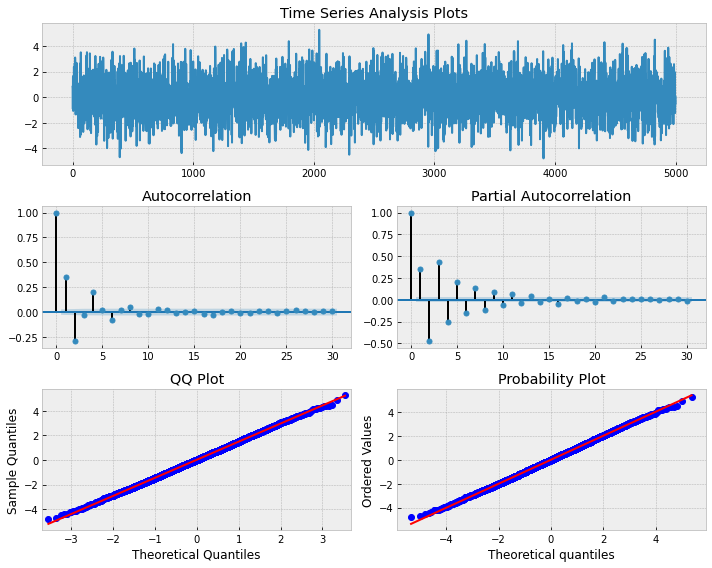

In [7]:
# Simulate an ARMA(3, 2) model with alphas=[0.5,-0.4,0.25] and betas=[0.5,-0.3]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5, -0.4, 0.25])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma32, lags=max_lag)

In [10]:
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: %6.5f | order: %s'%(best_aic, best_order))

aic: 14213.42405 | order: (3, 2)


In [11]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([7.27583507]), array([0.99567742]))

Remarquez que la valeur p est supérieure à 0,05, ce qui signifie que les résidus sont indépendants au niveau de 95% et qu'un modèle ARMA(3,2) fournit donc un bon ajustement du modèle (bien sûr, nous le savions).

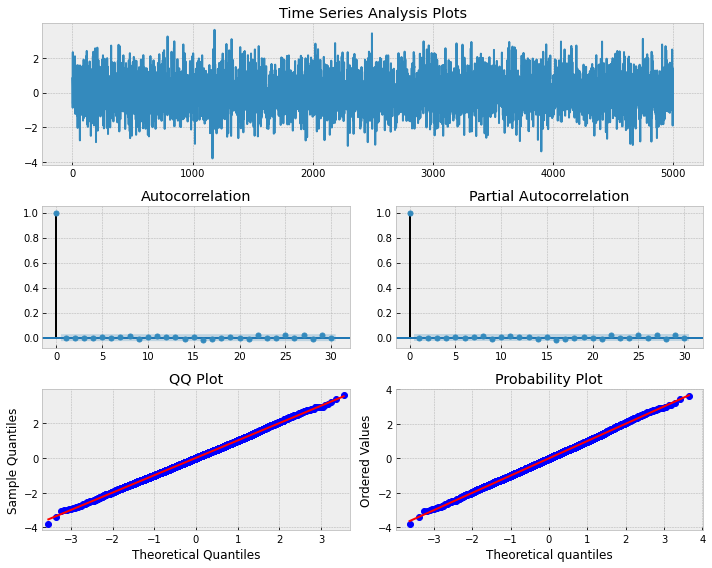

In [12]:
_ = tsplot(best_mdl.resid, lags=max_lag)

In [13]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

We have reason to suspect the residuals are not normally distributed.


Next we fit an ARMA model to SPX returns.

C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it ha

aic: -5194.68615 | order: (1, 1)


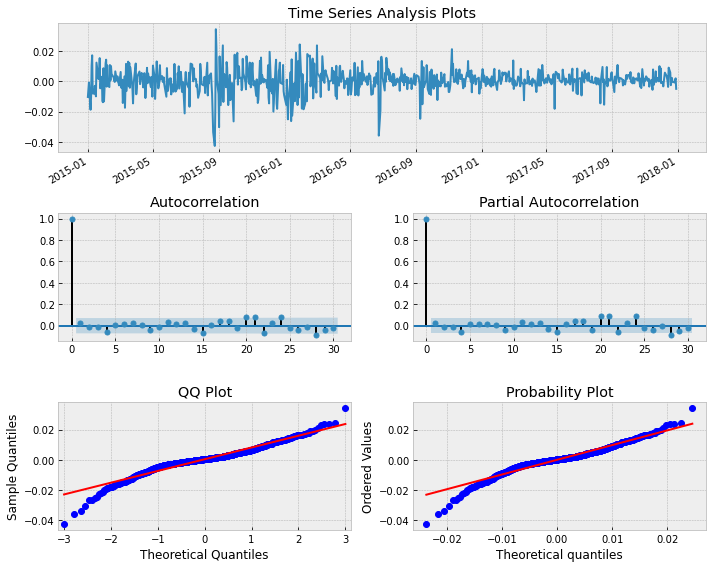

In [14]:
from numpy.linalg import LinAlgError
# Fit ARMA model to SPX returns

TS = lrets['^GSPC'].dropna()
TS.index = pd.DatetimeIndex(TS.index.values,
                               freq=TS.index.inferred_freq)

best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(1,5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(TS, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except (ValueError, LinAlgError) as e: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

_ = tsplot(best_mdl.resid, lags=max_lag)


Le modèle le mieux adapté est le modèle ARMA(3,2). Remarquez qu'il y a des pics importants, en particulier pour les décalages plus importants. Cela indique un mauvais ajustement. Effectuons un test Ljung-Box pour voir si nous avons des preuves statistiques à ce sujet :


In [15]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([20.26724221]), array([0.44132797]))

La valeur p est inférieure à 0,05 et nous ne pouvons donc pas dire que les résidus sont une réalisation du bruit blanc discret. Il y a donc une autocorrélation supplémentaire dans les résidus qui n'est pas expliquée par le modèle ARMA(3,2) ajusté. Ceci est également évident dans le tracé des résidus, nous pouvons voir des zones d'hétéroscédasticité conditionnelle évidente (volatilité conditionnelle) que le modèle n'a pas captées.

## Modèles intégrés autorégressifs à moyenne mobile - ARIMA(p, d, q)

ARIMA est une extension naturelle de la classe des modèles ARMA - ils sont utilisés parce qu'ils peuvent réduire une série non stationnaire à une série stationnaire en utilisant une séquence de différences.

Comme mentionné précédemment, beaucoup de nos TS ne sont pas stationnaires, mais ils peuvent être rendus stationnaires en utilisant une séquence de différences. Nous en avons vu un exemple lorsque nous avons pris la première différence de marche aléatoire guassienne non stationnaire et avons prouvé qu'elle équivalait à un bruit blanc stationnaire.

ARIMA remplit essentiellement la même fonction, mais le fait de manière répétée, $d$ fois, afin de réduire une série non stationnaire à une série stationnaire.

Sans trop s'enfoncer dans l'équation, il suffit de savoir qu'une série temporelle $x_t$ est intégrée d'ordre $d$ si nous différons la série $d$ fois et recevons une série discrète de bruit blanc.

Une série temporelle $x_t$ est un modèle intégré autorégressif de moyenne mobile d'ordre p, d, q, ARIMA(p,d,q) si la série $x_t$ est différée $d$ fois, et elle suit alors un processus ARMA(p,q).

Simulons un modèle ARIMA(2,1,1), avec les $\alpha = [0,5, -0,25], \beta=-0,5$. Comme auparavant, nous allons ajuster un modèle ARIMA à nos données simulées, en essayant de récupérer les paramètres.

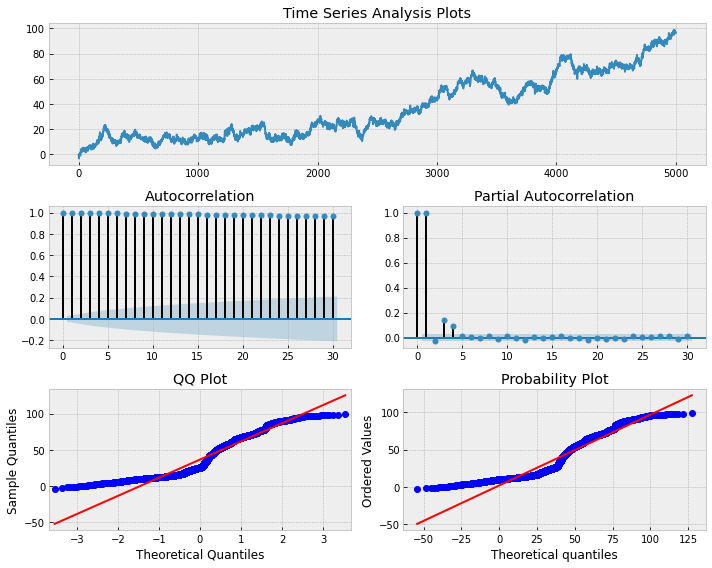

In [16]:
# Simulate an ARIMA(2,1,1) model with alphas=[0.5,-0.25] and betas=[-0.5]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5,-0.25])
betas = np.array([-0.5])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma11 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
arima111 = arma11.cumsum()
_ = tsplot(arima111, lags=max_lag)

C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


aic: 14190.11276 | order: (3, 1, 2)


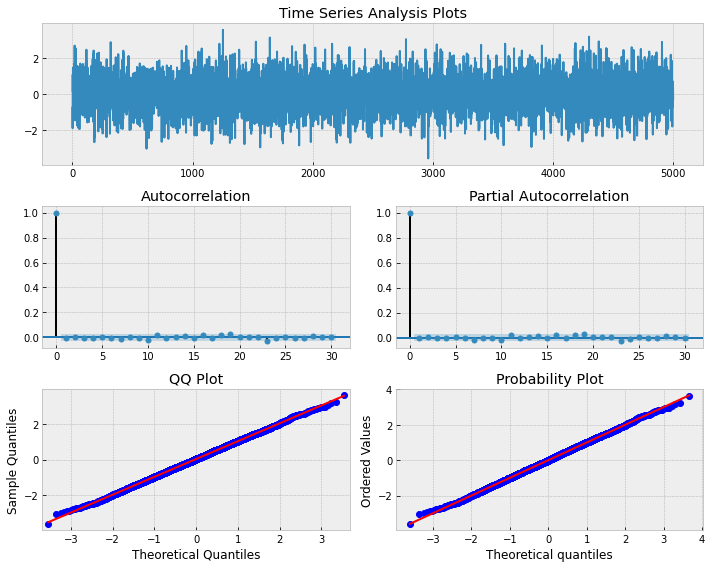

In [20]:
# Fit ARIMA(p, d, q) model
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(arima111, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: %6.5f | order: %s'%(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

Comme prévu, nous prévoyons un modèle ARIMA(2,1,1) et les résidus ressemblent à une réalisation de bruit blanc discret :

In [21]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([14.14565189]), array([0.82303489]))


Nous effectuons le test de la Ljung-Box et nous constatons que la valeur p est nettement supérieure à 0,05 et nous pouvons donc affirmer qu'il existe des preuves solides que le bruit blanc discret correspond bien aux résidus. Le modèle ARIMA(2,1,1) est donc bien adapté, comme on pouvait s'y attendre. Et notre test standard de normalité sur les résidus est inférieur.

In [22]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

We have reason to suspect the residuals are not normally distributed.


C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it ha

aic: -5194.71619 | order: (4, 0, 0)


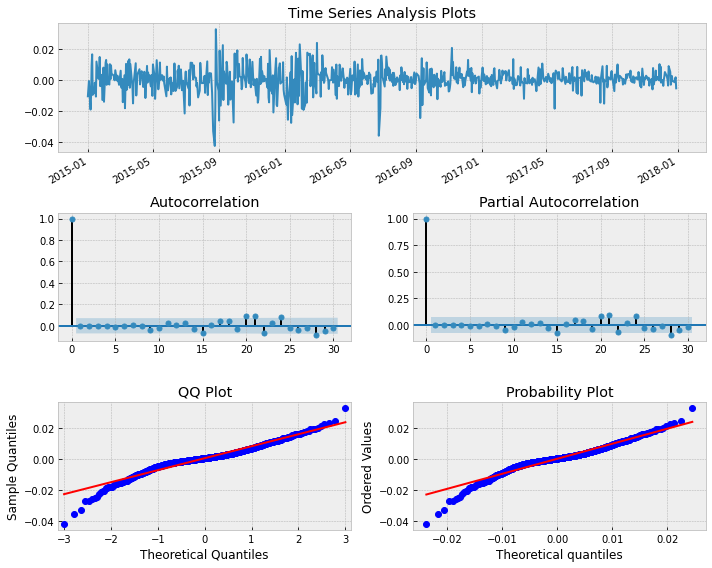

In [23]:
# Fit ARIMA(p, d, q) model to SPX log returns
# pick best order and final model based on aic

TS = lrets['^GSPC'].dropna()
TS.index = pd.DatetimeIndex(TS.index.values,
                               freq=TS.index.inferred_freq)

best_aic = np.inf 
best_order = None
best_mdl = None


pq_rng = range(5) # [0,1,2,3]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

Le résultat est essentiellement identique au modèle ARMA(3, 2) que nous avons ajusté ci-dessus. Il est clair que ce modèle ARIMA n'a pas non plus expliqué la volatilité conditionnelle de la série ! Le test de la boîte à poumons ci-dessous montre également une valeur p inférieure à 0,05

In [24]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([16.96790098]), array([0.65505699]))

#### Excluant les périodes de volatilité conditionnelle
Essayons le même modèle sur les données SPX de 2010-2016

In [25]:
startDateStr = '2010/12/31'
endDateStr = '2017/12/31'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['^GSPC']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']
# log returns
lrets = np.log(data/data.shift(1)).dropna()

Processing data for stock: ^GSPC
20% done...
40% done...
60% done...
80% done...


C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it ha

aic: -11635.99288 | order: (3, 1, 4)


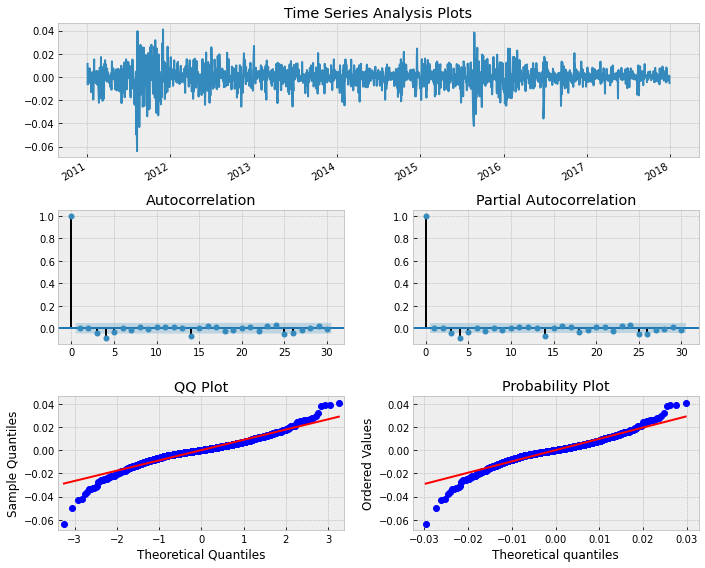

In [26]:
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

TS = lrets['^GSPC'].dropna()
TS.index = pd.DatetimeIndex(TS.index.values,
                               freq=TS.index.inferred_freq)

pq_rng = range(5) # [0,1,2,3]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

In [27]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([29.87185716]), array([0.07195681]))

Nos résidus se rapprochent beaucoup plus du bruit blanc et la valeur p de notre test est maintenant supérieure à 0,05

In [28]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

We have reason to suspect the residuals are not normally distributed.


Nous avons délibérément tronqué les données du S&P500 pour commencer à partir de 2010, ce qui exclut commodément les périodes de volatilité autour de 2007-2008. Nous avons donc exclu une grande partie du S&P500 où nous avions une concentration excessive de volatilité. Cela a un impact sur la corrélation en série des séries et a donc pour effet de faire paraître les séries "plus stationnaires" qu'elles ne l'ont été par le passé.

C'est un point très important. Lorsque nous analysons des séries temporelles, nous devons être extrêmement prudents avec les séries conditionnellement hétéroscédastiques, comme les indices boursiers. En finance quantitative, essayer de déterminer des périodes de volatilité différente est souvent connu sous le nom de "détection de régime". 

#### Forecasting
Now your patience gets rewarded! We have at least accumulated enough knowledge to make a simple forecast of future returns. We use statmodels forecast() method - we need to provide the number of time steps to predict, and a decimal for the alpha argument to specify the confidence intervals. The default setting is 95% confidence. For 99% set alpha equal to 0.01.

In [29]:
# Create a 21 day forecast of SPX returns with 95%, 99% CI
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2017-12-29,0.000733,-0.016577,-0.022016,0.018042,0.023481
2017-12-30,0.000577,-0.016748,-0.022192,0.017902,0.023346
2017-12-31,0.000506,-0.016828,-0.022275,0.017840,0.023287
2018-01-01,-0.000145,-0.017504,-0.022958,0.017213,0.022668
2018-01-02,0.001062,-0.016335,-0.021801,0.018458,0.023924


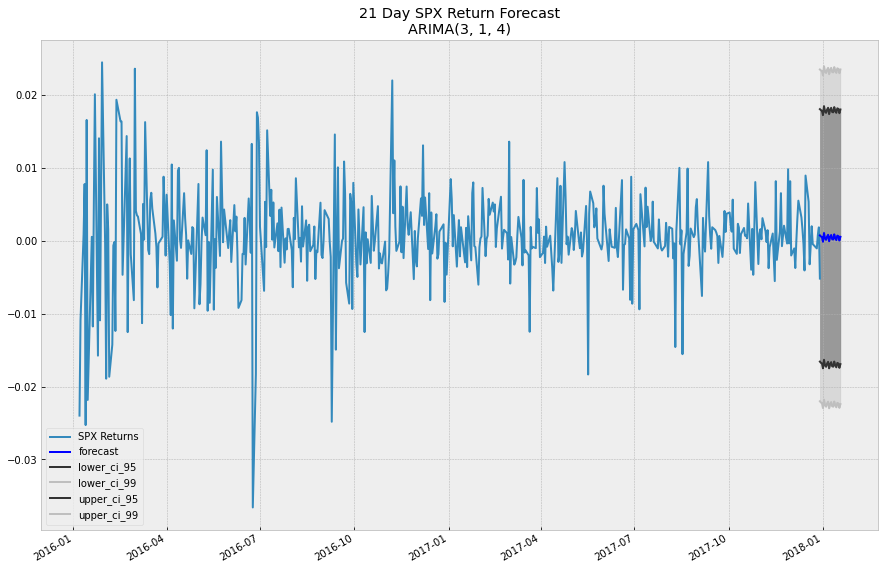

In [30]:
# Plot 21 day forecast for SPX returns

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = lrets['^GSPC'].iloc[-500:].copy()
ts.plot(ax=ax, label='SPX Returns')
# in sample prediction
#pred = best_mdl.predict(ts.index[0], ts.index[-1])
#pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day SPX Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

Maintenant que nous avons la capacité d'adapter et de prévoir des modèles tels que ARIMA, nous sommes très proches de pouvoir créer des indicateurs de stratégie pour le trading.